# Nishino's DMRG preprint dataset

## Introduction

For over 20 years, Professor Tomotoshi Nishino has been searching for preprints related to DMRG, tensor networks and other related topics. In his words:

>"Every morning (or evening), he accesses arXiv.org, and search key word such as DMRG, Renormalization, Entropy, Fidelity, Density, etc. from the abstract. After finding out preprints in this way, he reads tytle of most of the preprint listed in arXive again from the top to the bottom, or sometimes looks at authors. Articles detected in this primitive way is listed during the day." (http://quattro.phys.sci.kobe-u.ac.jp/dmrg/admin.html)

Over time he has created an extensive dataset, detailing the evolution of a very interesting corner of the many-body physics community. I have scrapped the arXiv IDs from Nishino's page and obtained the relevant information for each paper via the [arXiv API](https://arxiv.org/help/api/index).

## Preprint topic modeling

### Feb. 11, 2019

We can obtain fine-grained information about the main topics discussed in all the papers if we compare the relative frequency of dominant words in their abstracts. In order to organize this information, we will use a popular algorithm for topic modeling called [*latent Dirichlet allocation*](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA). This Bayesian algorithm tries to find semantic relations between the words of documents composing a corpus. In order to do this, it looks for a probability distribution of topics in the corpus. For each topic, it also finds a probability distribution for its most frequent words.

Once we have a topic model for the abstracts we will study the distribution of topics in relation to:
- Nishino's original rating (1: "major technical or conceptual advances, cool applications and good reviews"; 0: "Regular preprint"; -1: "related field").
- Year of submission to the arXiv.
- Most prolific authors in the dataset.

## Libraries

The main library we will use for topic modeling will be [Gensim](https://radimrehurek.com/gensim/).

In [1]:
import pandas as pd
import re
from itertools import chain
from collections import Counter, OrderedDict
import unidecode
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import matplotlib as mpl
import warnings
from nltk.corpus import stopwords

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [2]:
sns.set(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load csv file

We have already created a CSV file containing relevant information about the papers:

In [3]:
arxiv = pd.read_csv('../data/arxiv_search.csv')
arxiv.shape

(5590, 7)

These preprints were submitted to arXiv between January 1998 and March 2018.

In [4]:
arxiv.submitted = pd.to_datetime(arxiv.submitted)
arxiv.submitted.min(), arxiv.submitted.max()

(Timestamp('1998-01-07 16:12:32'), Timestamp('2018-04-18 13:41:42'))

In [5]:
arxiv.head()

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,doi
0,cond-mat/9812409,0,Phase diagram of a Heisenberg spin-Peierls mod...,Robert J. Bursill|Ross H. McKenzie|Chris J. Hamer,1998-12-29 02:54:03,Using a new version of the density-matrix re...,10.1103/PhysRevLett.83.408
1,cond-mat/9812374,0,Modified Double Exchange Model with Novel Spin...,L. Sheng|C. S. Ting,1998-12-22 22:02:14,From a general model of the Mn oxides R_{1-x...,NaN
2,cond-mat/9812372,1,Dynamical Correlation Functions using the Dens...,Till D. Kuehner|Steven R. White,1998-12-22 19:23:21,The density matrix renormalization group (DM...,10.1103/PhysRevB.60.335
3,cond-mat/9812353,1,Dynamical properties of the one-dimensional Ho...,Chunli Zhang|Eric Jeckelmann|Steven R. White,1998-12-22 01:53:07,The spectral weight functions and the optica...,10.1103/PhysRevB.60.14092
4,cond-mat/9812349,0,A density matrix renormalisation group algorit...,R. J. Bursill,1998-12-22 02:26:14,A variant of White's density matrix renormal...,10.1103/PhysRevB.60.1643


In [6]:
arxiv.drop(['doi'], axis=1, inplace=True)

In [7]:
arxiv.authors = arxiv.authors.map(lambda x : np.NaN if x == 'nan' else x)
arxiv.dropna(inplace=True)
arxiv.shape

(5589, 6)

## Clean abstracts

We will clean the text in order to run the LDA algorithm. This includes:
- Removing punctuation and break characters.
- Removing accents.
- Remove English [stop words](https://en.wikipedia.org/wiki/Stop_words).
- [Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation).

In [8]:
# Convert to list
data = arxiv.abstract.values.tolist()

In [9]:
# Remove distracting single quotes
data = [re.sub("\'", "", abstract) for abstract in data]

In [10]:
# Convert text into list of tokens

def abstracts_to_words(abstracts):
    for abstract in abstracts:
        yield(gensim.utils.simple_preprocess(str(abstract), deacc=True))  # deacc=True removes punctuations

data_words = list(abstracts_to_words(data))

In [12]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Lemmatization using spaCy
def lemmatization(texts, nlp):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [13]:
stop_words = stopwords.words('english')

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, nlp)

## Create the dictionary of relevant words

In order to create a good dictionary, we will remove rare words (those that appear less than 5 times) and very common words (those that are present in more than 70% of the abstracts).

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=5, # Words should appear at least 5 times in the corpus
                        no_above=0.7) # Words should appear at most in 70% of the corpus

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Finding the right number of topics

Given that we are assuming that the topic is a latent variable, we don't know what is the ideal number of topics for the modeling. We can estimate this parameter by considering the [coherence](https://dl.acm.org/citation.cfm?id=2145462) of the division. This quantity measures the average co-occurrence of the most probable words in each topic.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    # model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           workers=4,
                                           random_state=100,
                                           chunksize=1000,
                                           passes=20,
                                           per_word_topics=True)
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics,
        #                                         id2word=id2word)
        # model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        print(coherence_values)

    # return model_list, coherence_values
    return coherence_values

In [17]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus,
                                            texts=data_lemmatized,
                                            start=8, limit=30, step=2)

[0.394682723462418]
[0.394682723462418, 0.408401567684476]
[0.394682723462418, 0.408401567684476, 0.41078763687850617]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204, 0.4358198867663681]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204, 0.4358198867663681, 0.4247784449270509]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204, 0.4358198867663681, 0.4247784449270509, 0.4197624352214541]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204, 0.4358198867663681, 0.4247784449270509, 0.4197624352214541, 0.4210615106593898]
[0.394682723462418, 0.408401567684476, 0.41078763687850617, 0.421897303684298, 0.42845464664029204, 0.

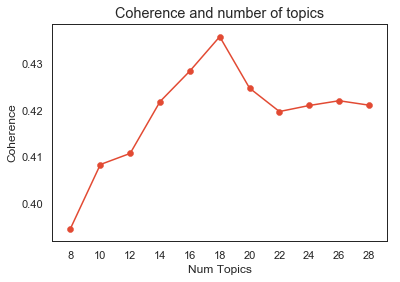

In [18]:
# Show graph
limit=30; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.scatter(x, coherence_values)
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence")
plt.title('Coherence and number of topics')
plt.show()

## Using 16 topics

As we saw in the previous calculation, 16 topics is a good, practical number of topics: it is the simplest model that lies close to the saturation value of the coherence.

In [19]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16,
                                           workers=4,
                                           random_state=100,
                                           chunksize=1000,
                                           passes=20,
                                           per_word_topics=True)

We can obtain the most important words for each topic:

In [20]:
# Print keywords for every topics
pprint(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(0,
  '0.059*"model" + 0.042*"spin" + 0.035*"field" + 0.028*"chain" + '
  '0.024*"ising" + 0.018*"lattice" + 0.015*"critical" + 0.012*"boundary" + '
  '0.011*"transverse" + 0.011*"magnetic" + 0.010*"two" + 0.008*"use" + '
  '0.008*"study" + 0.008*"point" + 0.008*"function"'),
 (1,
  '0.030*"matrix" + 0.023*"state" + 0.018*"system" + 0.018*"method" + '
  '0.015*"time" + 0.015*"product" + 0.013*"quantum" + 0.012*"algorithm" + '
  '0.011*"use" + 0.011*"density" + 0.010*"model" + 0.009*"one" + 0.009*"dmrg" '
  '+ 0.007*"dimensional" + 0.007*"group"'),
 (2,
  '0.051*"spin" + 0.037*"_" + 0.024*"state" + 0.019*"phase" + 0.019*"j" + '
  '0.015*"order" + 0.014*"chain" + 0.012*"heisenberg" + 0.012*"magnetic" + '
  '0.012*"grind" + 0.011*"model" + 0.010*"find" + 0.009*"liquid" + '
  '0.008*"field" + 0.008*"study"'),
 (3,
  '0.071*"phase" + 0.037*"transition" + 0.019*"model" + 0.019*"state" + '
  '0.017*"density" + 0.015*"quantum" + 0.015*"diagram" + 0.014*"order" + '
  '0.013*"phasis" + 0.010*"i

Some topics are easy to interpret:

- **0:** Ising model.
- **2:** Heisenberg model.
- **6:** AdS/CFT, holography.
- **7, 11:** Topological models.
- **9:** Critical points.
- **10:** Hubbard model.
- **13:** Disorder, localization.
- **14:** Entanglement.
- **15:** Dynamical systems, time evolution.

We can evaluate the coherence of each topic:

In [22]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

coherence_per_topic = coherence_model_lda.get_coherence_per_topic()

print('Coherence per topic:')

for topic in range(16):
    print(f'Topic {topic}: {coherence_per_topic[topic]}')

Perplexity:  -6.722864230815754
Coherence Score:  0.4200766467368231
Coherence per topic:
Topic 0: 0.37897365297890195
Topic 1: 0.4495244772509581
Topic 2: 0.4723974206115159
Topic 3: 0.39810197155989113
Topic 4: 0.3947459146636475
Topic 5: 0.42872097687101435
Topic 6: 0.6151763075533272
Topic 7: 0.3614892818482861
Topic 8: 0.34194154773294805
Topic 9: 0.3991674500827559
Topic 10: 0.44301198552274645
Topic 11: 0.4666489800896761
Topic 12: 0.3120359296424836
Topic 13: 0.41271790115508855
Topic 14: 0.39368156977492463
Topic 15: 0.45289098045100395


The highest coherence corresponds to topic 6, that is, AdS/CFT and holography. This sounds reasonable given the exotic nature of the connection between tensor networks and holography.

## Finding dominant topics

For each abstract, we will find the topic that corresponds to the highest probability.

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4)]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib']

In [24]:
arxiv = arxiv.reset_index(drop=True)

df_dominant_topic = df_dominant_topic.reset_index(drop=True)

In [25]:
arxivTopics = pd.concat([arxiv, df_dominant_topic], axis = 1)
print(arxivTopics.shape)
print(arxivTopics.columns)

(5589, 9)
Index(['arXiv_id', 'Nishino_Rating', 'title', 'authors', 'submitted',
       'abstract', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib'],
      dtype='object')


In [26]:
arxivTopics.drop('Document_No', axis=1, inplace=True)

In [27]:
arxivTopics['Dominant_Topic'] = arxivTopics['Dominant_Topic'].map(lambda x : str(int(x)))

In [28]:
arxivTopics.sample(20)

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,Dominant_Topic,Topic_Perc_Contrib
3907,1511.08613,0,Integrable open spin chains related to infinit...,Bireswar Basu-Mallick|Federico Finkel|Artemio ...,2015-11-27 10:35:16,In this paper we study an su$(m)$-invariant ...,12,0.5613
1234,0809.3679,0,Dissipation induced Tonks-Girardeau gas in an ...,J. J. Garcia-Ripoll|S. Dürr|N. Syassen|D. M. B...,2008-09-22 11:00:09,We present a theoretical investigation of a ...,15,0.7860
1714,1011.0506,-1,A Very Fast Algorithm for Matrix Factorization,Vladimir Nikulin|Tian-Hsiang Huang|Shu-Kay Ng|...,2010-11-02 03:36:52,We present a very fast algorithm for general...,1,0.4932
1446,0911.4283,-1,Numerical determination of entanglement entrop...,R. Lohmayer|H. Neuberger|A. Schwimmer|S. Theisen,2009-11-23 04:41:53,We apply Srednicki's regularization to extra...,14,0.7250
3936,1511.00896,-1,Universal properties of the FQH state from the...,Na Jiang|Qi Li|Zheng Zhu|Zi-Xiang Hu,2015-11-03 13:09:23,The topological entanglement entropy (TEE) i...,7,0.5097
2765,1201.2648,-1,Symmetry-protected topological orders for inte...,Zheng-Cheng Gu|Xiao-Gang Wen,2012-01-12 19:06:34,Symmetry-protected topological (SPT) phases ...,11,0.5697
3385,1410.6407,0,Active space decomposition with multiple sites...,Shane M. Parker|Toru Shiozaki,2014-10-23 16:09:25,We extend the active space decomposition met...,4,0.6028
1840,1006.2652,-1,Scaling Relation for Excitation Energy Under H...,Hiroshi Ueda|Hiroki Nakano|Koichi Kusakabe|Tom...,2010-06-14 09:59:47,We introduce a one-parameter deformation for...,12,0.4017
3461,1409.1008,-1,Reduced Density-Matrix Functional Theory: corr...,Stefano Di Sabatino|Jan A. Berger|Lucia Reinin...,2014-09-03 09:30:05,In this work we explore the performance of a...,10,0.4651
439,cond-mat/0310223,0,Quantum Phase Transitions in the One-Dimension...,Satoshi Miyashita|Akira Kawaguchi|Norio Kawaka...,2003-10-09 20:05:49,We investigate ground-state properties and q...,3,0.4836


## Most representative paper for each topic according to the model

In [29]:
# Group top 5 sentences under each topic
mostRepresentative = pd.DataFrame()

sent_topics_outdf_grpd = arxivTopics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    mostRepresentative = pd.concat([mostRepresentative, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
mostRepresentative.reset_index(drop=True, inplace=True)

# Show
mostRepresentative

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,Dominant_Topic,Topic_Perc_Contrib
0,1610.08657,0,Critical properties of the eight-vertex model ...,Roman Krčmár|Ladislav Šamaj,2016-10-27 08:25:17,The general eight-vertex model on a square l...,0,0.9875
1,1605.02611,1,"Matrix Product Operators, Matrix Product State...",Garnet Kin-Lic Chan|Anna Keselman|Naoki Nakata...,2016-05-09 14:50:23,Current descriptions of the ab initio DMRG a...,1,0.9921
2,1803.11342,0,Dynamical DMRG study of spin and charge excita...,Takami Tohyama|Michiyasu Mori|Shigetoshi Sota,2018-03-30 05:21:32,The ground state of the t-t'-J ladder with f...,10,0.9933
3,1101.5680,0,New gapped quantum phases for S=1 spin chain w...,Zheng-Xin Liu|Min Liu|Xiao-Gang Wen,2011-01-29 07:55:58,We study different quantum phases in integer...,11,0.9908
4,1609.08045,0,Derivation of matrix product states for the He...,Zhongtao Mei|C. J. Bolech,2016-09-26 16:20:03,"Using the algebraic Bethe ansatz, we derive ...",12,0.9906
5,1507.01635,0,A criterion for many-body localization-delocal...,Maksym Serbyn|Z. Papić|Dmitry A. Abanin,2015-07-06 22:19:59,We propose a new approach to probing ergodic...,13,0.9932
6,1607.05656,-1,Branch Point Twist Field Correlators in the Ma...,Davide Bianchini|Olalla A. Castro-Alvaredo,2016-07-19 16:53:16,Well-known measures of entanglement in one-d...,14,0.9944
7,1608.01664,0,Thermalization and light cones in a model with...,Bruno Bertini|Fabian H. L. Essler|Stefan Groha...,2016-08-04 19:57:21,We employ equation of motion techniques to s...,15,0.9916
8,cond-mat/0106426,0,Quantum phase transition by cyclic four-spin e...,Yasushi Honda|Tsuyoshi Horiguchi,2001-06-21 04:54:00,We investigate an $S=1/2$ two-leg spin ladde...,2,0.9949
9,1502.01821,0,Quantum phase transitions and string orders in...,Guang-Hua Liu|Wen-Long You|Wei Li|Gang Su,2015-02-06 08:12:29,Quantum phase transitions (QPTs) and the gro...,3,0.9930


## Topics and Nishino's rating

We will now use Nishino's rating:

- **1:** "major technical or conceptual advances, cool applications and good reviews"
- **0:** "regular preprint"
- **-1:** "related field"

In [30]:
arxivTopics.Nishino_Rating = arxivTopics.Nishino_Rating.map(lambda x: str(int(x)))

In [31]:
arxivTopics.head()

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,Dominant_Topic,Topic_Perc_Contrib
0,cond-mat/9812409,0,Phase diagram of a Heisenberg spin-Peierls mod...,Robert J. Bursill|Ross H. McKenzie|Chris J. Hamer,1998-12-29 02:54:03,Using a new version of the density-matrix re...,2,0.3513
1,cond-mat/9812374,0,Modified Double Exchange Model with Novel Spin...,L. Sheng|C. S. Ting,1998-12-22 22:02:14,From a general model of the Mn oxides R_{1-x...,2,0.3709
2,cond-mat/9812372,1,Dynamical Correlation Functions using the Dens...,Till D. Kuehner|Steven R. White,1998-12-22 19:23:21,The density matrix renormalization group (DM...,1,0.5314
3,cond-mat/9812353,1,Dynamical properties of the one-dimensional Ho...,Chunli Zhang|Eric Jeckelmann|Steven R. White,1998-12-22 01:53:07,The spectral weight functions and the optica...,10,0.5906
4,cond-mat/9812349,0,A density matrix renormalisation group algorit...,R. J. Bursill,1998-12-22 02:26:14,A variant of White's density matrix renormal...,1,0.3589


In [32]:
topic_rating = arxivTopics.groupby(['Nishino_Rating', 'Dominant_Topic']).agg({'arXiv_id':'count'}).unstack()

In [33]:
topic_rating.columns = ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

In [34]:
topic_rating = topic_rating.fillna(0)
topic_rating = topic_rating[[str(i) for i in range(16)]]
topic_rating

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nishino_Rating,,,,,,,,,,,,,,,,
-1,65,86,93,64,47,115,59,142,100,83,65,42,129,86,435,120
0,67,354,545,314,139,219,63,149,162,124,571,167,130,79,148,385
1,4,72,7,4,22,43,3,5,14,13,17,2,17,4,9,6


### By rating

We first look at the distribution of topics for each rating category, that is, we normalize along the rows:

In [35]:
topic_by_row = topic_rating.div(topic_rating.sum(axis=1), axis=0)

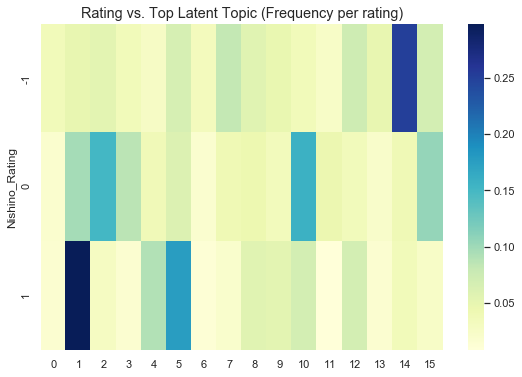

In [36]:
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Rating vs. Top Latent Topic (Frequency per rating)')
sns.heatmap(topic_by_row,annot=False, cmap="YlGnBu", ax=ax)

We see that most "major technical or conceptual advances, cool applications and good reviews" are related to topics **1** (MPS and DMRG), **4** (in relation to Monte Carlo), and **5** (Tensor networks, PEPS). This is consistent with the main interest of the preprint list.

## Topics and submission year

We now extract the submission year from the timestamp:

In [37]:
arxivTopics['year'] = arxivTopics.submitted.dt.year

In [38]:
topic_year = arxivTopics.groupby(['year', 'Dominant_Topic']).agg({'arXiv_id':'count'}).unstack()

In [39]:
topic_year.columns = ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

In [40]:
topic_year = topic_year.fillna(0)
topic_year = topic_year[[str(i) for i in range(16)]]

In [41]:
topic_year

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
year,,,,,,,,,,,,,,,,
1998,3.0,11.0,24.0,5.0,2.0,1.0,0.0,0.0,0.0,4.0,35.0,4.0,2.0,0.0,0.0,3.0
1999,4.0,10.0,26.0,8.0,4.0,0.0,0.0,2.0,1.0,7.0,31.0,5.0,0.0,0.0,0.0,1.0
2000,4.0,10.0,26.0,3.0,1.0,0.0,0.0,0.0,1.0,8.0,24.0,0.0,1.0,0.0,0.0,2.0
2001,1.0,10.0,13.0,6.0,3.0,0.0,0.0,1.0,3.0,3.0,18.0,1.0,2.0,3.0,0.0,4.0
2002,4.0,10.0,14.0,5.0,5.0,0.0,0.0,1.0,4.0,3.0,20.0,4.0,3.0,2.0,1.0,4.0
2003,1.0,13.0,10.0,7.0,5.0,0.0,2.0,1.0,1.0,7.0,32.0,2.0,1.0,1.0,1.0,5.0
2004,3.0,18.0,27.0,7.0,1.0,4.0,0.0,0.0,6.0,2.0,28.0,0.0,1.0,2.0,5.0,7.0
2005,1.0,20.0,26.0,10.0,2.0,3.0,0.0,1.0,7.0,1.0,37.0,1.0,11.0,3.0,19.0,7.0
2006,2.0,14.0,25.0,14.0,8.0,12.0,0.0,3.0,14.0,3.0,40.0,1.0,8.0,2.0,21.0,14.0


## By year

Let us now normalize along the rows (i.e., for each year) in order to find the most common topics for each year:

In [42]:
topic_year_by_row = topic_year.div(topic_year.sum(axis=1), axis=0)

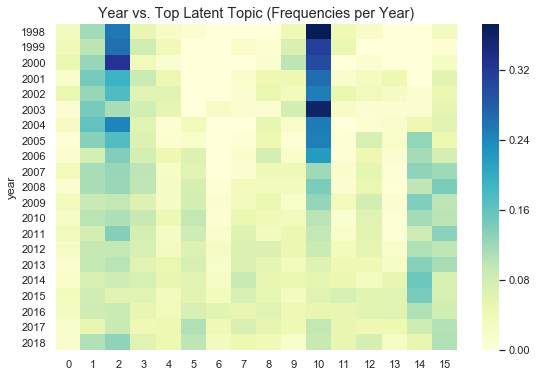

In [43]:
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Year vs. Top Latent Topic (Frequencies per Year)')
sns.heatmap(topic_year_by_row,annot=False, cmap="YlGnBu", ax=ax)

Topics **2** (Heisenberg model) and **10** (Hubbard model) dominated the first 8 years of the dataset. Around 2005, topic **14** (entanglement theory) starts becoming more important, along with the tensor network topics.

## By topic

If we normalize along the columns (i.e., each topic), we can see when they were most popular:

In [115]:
for col in topic_year.columns:
    topic_year[col] = topic_year[col] / topic_year[col].sum()

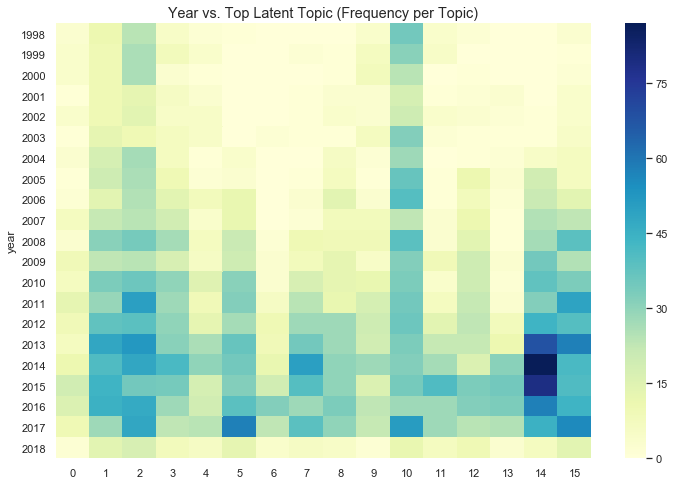

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Year vs. Top Latent Topic (Frequency per Topic)')
sns.heatmap(topic_year,annot=False, cmap="YlGnBu", ax=ax)

We see that some topics became more common in later years, but none of the originally popular topics disappeared completely. Entanglement theory (topic **14**) had a spike between 2013 and 2015.

## List authors for each paper

We will extract the authors of each paper. In order to standarize the spelling, we will use the first letter of the given name and the last word as last name (e.g., Tomotoshi Nishino -> t nishino). This method is very efficient. However, it is far from perfect, in particular in the context of Chinese names. (For more information, see notebook with the author network analysis.)

In [45]:
def cleanAuthors (df, column):
    df[column] = df[column].str.replace('ä', 'ae')
    df[column] = df[column].str.replace('ö', 'oe')
    df[column] = df[column].str.replace('ü', 'ue')
    df[column] = df[column].apply(lambda x : unidecode.unidecode(x))
    
    return df

In [46]:
arxiv = cleanAuthors(arxiv, 'authors')

In [47]:
paperDic = dict()

In [48]:
# Create a list of papers that throw errors while parsing the author list
damagedAuthors = []
for index, row in arxiv.iterrows():
    cleanAuthors = []
    try:
        for author in row['authors'].split('|'):
            name = author.split(' ')
            name = name[0][0] + ' ' + name[-1]
            name = name.lower()
            cleanAuthors.append(name)
        paperDic[row['arXiv_id']] = cleanAuthors
    except:
        damagedAuthors.append(row['arXiv_id'])

In [49]:
damagedAuthors

[]

In [50]:
def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

Find most prolific authors in the dataset:

In [51]:
authors_count = count_items(list(chain(*[paperDic[paper] for paper in paperDic])))
list(authors_count.items())[:15]

[('f verstraete', 130),
 ('j cirac', 126),
 ('s white', 101),
 ('u schollwoeck', 100),
 ('i mcculloch', 90),
 ('g vidal', 84),
 ('o legeza', 72),
 ('a feiguin', 66),
 ('p calabrese', 63),
 ('f pollmann', 60),
 ('s nishimoto', 58),
 ('j haegeman', 57),
 ('m troyer', 56),
 ('g sierra', 55),
 ('n schuch', 55)]

We will consider only the top 15 most prolific authors:

In [52]:
most_prolific_authors = list(authors_count)[:15]

We will now extract, for each author, their topic distribution according to their papers:

In [53]:
topic_authors = pd.DataFrame(np.zeros((15,16)))
topic_authors.index = most_prolific_authors

In [54]:
for index, row in arxivTopics.iterrows():
    authors = paperDic[row['arXiv_id']]
    
    for author in authors:
        if author in most_prolific_authors:
            topic_authors.loc[author, int(row['Dominant_Topic'])] += 1

In [55]:
topic_authors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
f verstraete,1.0,40.0,4.0,1.0,8.0,28.0,2.0,13.0,4.0,1.0,2.0,2.0,12.0,0.0,6.0,6.0
j cirac,2.0,23.0,6.0,2.0,7.0,32.0,2.0,9.0,10.0,2.0,1.0,2.0,14.0,3.0,2.0,9.0
s white,0.0,16.0,18.0,1.0,9.0,3.0,0.0,0.0,4.0,0.0,43.0,3.0,0.0,1.0,0.0,3.0
u schollwoeck,0.0,24.0,9.0,6.0,1.0,0.0,0.0,0.0,2.0,4.0,18.0,6.0,0.0,0.0,3.0,27.0
i mcculloch,0.0,21.0,12.0,10.0,2.0,1.0,0.0,4.0,1.0,1.0,6.0,8.0,2.0,0.0,1.0,21.0
g vidal,1.0,20.0,1.0,2.0,1.0,24.0,1.0,3.0,1.0,4.0,1.0,2.0,12.0,2.0,8.0,1.0
o legeza,1.0,9.0,8.0,9.0,13.0,1.0,0.0,1.0,15.0,0.0,11.0,2.0,0.0,0.0,1.0,1.0
a feiguin,1.0,7.0,8.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,31.0,2.0,0.0,0.0,0.0,11.0
p calabrese,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0,26.0,19.0
f pollmann,0.0,4.0,3.0,9.0,3.0,0.0,0.0,6.0,0.0,0.0,6.0,10.0,1.0,7.0,4.0,7.0


## By author

We normalize along the rows (i.e., authors) in order to see the preferred topics for each of the top authors:

In [56]:
topic_authors_by_row = topic_authors.div(topic_authors.sum(axis=1), axis=0)

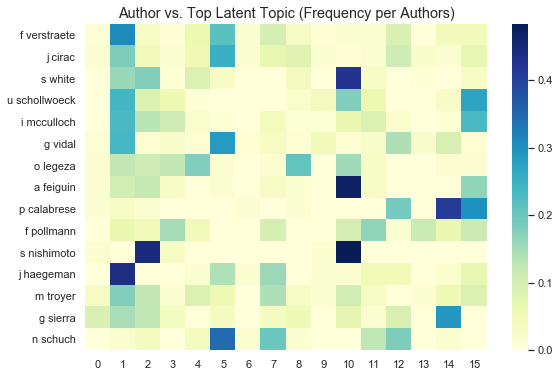

In [57]:
fig, ax = plt.subplots(figsize=(9,6))
plt.title('Author vs. Top Latent Topic (Frequency per Authors)')
sns.heatmap(topic_authors_by_row,annot=False, cmap="YlGnBu", ax=ax)